In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, ttest_ind, shapiro, levene, mannwhitneyu, kruskal
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
plt.style.use("seaborn")
EPS = 1e-10

In [3]:
coredir = './'
indir = coredir + 'SDS RWE Data Challenge Dataset/'
outdir = coredir + f'output/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

bill_amount_filename = indir + "bill_amount.csv"
bill_amount = pd.read_csv(bill_amount_filename)
print('all data in bill_amount.csv:', bill_amount.shape)

bill_id_filename = indir + "bill_id.csv"
bill_id = pd.read_csv(bill_id_filename)
print('all data in bill_id.csv:', bill_id.shape)

clinical_data_filename = indir + "clinical_data.csv"
clinical_data = pd.read_csv(clinical_data_filename)
print('all data in clinical_data.csv:', clinical_data.shape)

demographics_filename = indir + "demographics.csv"
demographics = pd.read_csv(demographics_filename)
print('all data in demographics.csv:', demographics.shape)

all data in bill_amount.csv: (13600, 2)
all data in bill_id.csv: (13600, 3)
all data in clinical_data.csv: (3400, 26)
all data in demographics.csv: (3000, 5)


In [4]:
bill_amount.head()

,bill_id,amount
0,40315104,1552.634830
1,2660045161,1032.011951
2,1148334643,6469.605351
3,3818426276,755.965425
4,9833541918,897.347816


In [5]:
bill_id.head()

,bill_id,patient_id,date_of_admission
0,7968360812,1d21f2be18683991eb93d182d6b2d220,2011-01-01
1,6180579974,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
2,7512568183,1d21f2be18683991eb93d182d6b2d220,2011-01-01
3,3762633379,62bdca0b95d97e99e1c712048fb9fd09,2011-01-01
4,7654730355,1d21f2be18683991eb93d182d6b2d220,2011-01-01


In [6]:
clinical_data.head()

,id,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,medical_history_ren,medical_history_tum,medical_history_anx,medical_history_mood,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv
0,1d21f2be18683991eb93d182d6b2d220,1/1/11,11/1/11,0,1.0,0,0,0.0,0,0,...,0,0,0,1,1,71.3,161,2,2,2
1,62bdca0b95d97e99e1c712048fb9fd09,1/1/11,11/1/11,0,0.0,0,0,0.0,0,0,...,0,0,1,1,1,78.4,160,6,5,2
2,c85cf97bc6307ded0dd4fef8bad2fa09,2/1/11,13/1/11,0,0.0,0,0,0.0,0,0,...,1,1,1,1,0,72.0,151,5,5,4
3,e0397dd72caf4552c5babebd3d61736c,2/1/11,14/1/11,0,1.0,No,0,0.0,1,1,...,1,1,1,1,1,64.4,152,3,5,5
4,94ade3cd5f66f4584902554dff170a29,8/1/11,16/1/11,0,0.0,No,0,0.0,1,1,...,0,1,0,1,0,55.6,160,3,4,5


In [7]:
demographics.head()

,patient_id,gender,race,resident_status,date_of_birth
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03
3,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15
4,541ad077cb4a0e64cc422673afe28aef,m,Chinese,Singaporean,1970-12-12


# Data pre-processing

In [8]:
demographics.loc[demographics.gender == 'f', 'gender'] = 'Female'
demographics.loc[demographics.gender == 'm', 'gender'] = 'Male'

demographics.gender.unique()

array(['Female', 'Male'], dtype=object)

In [9]:
demographics.loc[demographics.race == 'India', 'race'] = 'Indian'
demographics.loc[demographics.race == 'chinese', 'race'] = 'Chinese'

demographics.race.unique()

array(['Indian', 'Chinese', 'Malay', 'Others'], dtype=object)

In [10]:
demographics.loc[demographics.resident_status == 'Singaporean', 'resident_status'] = 'Singapore citizen'
demographics.loc[demographics.resident_status == 'PR', 'resident_status'] = 'Permanent resident'

demographics.resident_status.unique()

array(['Singapore citizen', 'Permanent resident', 'Foreigner'],
      dtype=object)

In [11]:
clinical_data.replace({'Yes': 1, 'No': 0}, inplace=True)

In [12]:
clinical_data.id.nunique()

3000

In [13]:
demographics.patient_id.nunique()

3000

In [14]:
set(clinical_data.id.unique()) == set(demographics.patient_id.unique())

True

In [15]:
df = demographics.merge(clinical_data, left_on='patient_id', right_on='id')
df.drop(['id'], axis=1, inplace=True)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,1,1,0,0,1,68.1,161,5,2,6
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,1,1,1,1,76.5,151,3,3,6
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,0,0,1,1,1,69.7,175,6,5,6
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,1,0,0,1,0,66.7,175,5,5,6
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,1,1,1,1,96.9,180,4,3,4
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,1,1,1,1,91.6,166,4,2,8
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,1,1,1,0,0,65.0,162,4,4,4
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,1,1,0,1,0,90.1,173,3,3,6
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,1,1,1,1,0,88.1,173,2,2,5
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,0,0,0,1,1,68.7,164,4,5,4


In [16]:
now = pd.Timestamp('now')
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['date_of_birth'] = df['date_of_birth'].where(df['date_of_birth'] < now, df['date_of_birth'] -  np.timedelta64(100, 'Y'))
df['age'] = ((now - df['date_of_birth']).astype('<m8[Y]')).round(0).astype(int)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_2,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,1,0,0,1,68.1,161,5,2,6,53
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,1,1,1,76.5,151,3,3,6,48
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,0,1,1,1,69.7,175,6,5,6,41
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,0,0,1,0,66.7,175,5,5,6,41
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,1,1,1,96.9,180,4,3,4,76
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,1,1,1,91.6,166,4,2,8,53
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,1,1,0,0,65.0,162,4,4,4,57
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,1,0,1,0,90.1,173,3,3,6,48
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,1,1,1,0,88.1,173,2,2,5,48
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,0,0,1,1,68.7,164,4,5,4,50


In [17]:
df['BMI'] = (df['weight'] / np.square((df['height']/100))).apply(lambda x: round(x, 1))
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_3,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,0,0,1,68.1,161,5,2,6,53,26.3
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,1,1,76.5,151,3,3,6,48,33.6
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,1,1,1,69.7,175,6,5,6,41,22.8
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,0,1,0,66.7,175,5,5,6,41,21.8
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,1,1,96.9,180,4,3,4,76,29.9
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,1,1,91.6,166,4,2,8,53,33.2
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,1,0,0,65.0,162,4,4,4,57,24.8
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,0,1,0,90.1,173,3,3,6,48,30.1
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,1,1,0,88.1,173,2,2,5,48,29.4
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,0,1,1,68.7,164,4,5,4,50,25.5


In [18]:
col_list = [col for col in df if col.startswith('symptom_')]

df['count_symptoms'] = df[col_list].sum(axis=1)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_4,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,0,1,68.1,161,5,2,6,53,26.3,3
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,1,76.5,151,3,3,6,48,33.6,5
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,1,1,69.7,175,6,5,6,41,22.8,3
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,1,0,66.7,175,5,5,6,41,21.8,2
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,1,96.9,180,4,3,4,76,29.9,5
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,1,91.6,166,4,2,8,53,33.2,5
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,0,0,65.0,162,4,4,4,57,24.8,3
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,1,0,90.1,173,3,3,6,48,30.1,3
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,1,0,88.1,173,2,2,5,48,29.4,4
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,1,1,68.7,164,4,5,4,50,25.5,2


In [19]:
col_list = [col for col in df if col.startswith('trt_') if col not in ('trt_adt', 'trt_the')]

df['count_meds'] = df[col_list].sum(axis=1)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms,count_meds
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,1,68.1,161,5,2,6,53,26.3,3,2
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,76.5,151,3,3,6,48,33.6,5,2
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,1,69.7,175,6,5,6,41,22.8,3,2
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,0,66.7,175,5,5,6,41,21.8,2,4
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,96.9,180,4,3,4,76,29.9,5,2
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,91.6,166,4,2,8,53,33.2,5,3
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,0,65.0,162,4,4,4,57,24.8,3,1
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,0,90.1,173,3,3,6,48,30.1,3,4
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,0,88.1,173,2,2,5,48,29.4,4,3
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,1,68.7,164,4,5,4,50,25.5,2,3


In [20]:
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms,count_meds
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0.0,0,...,1,68.1,161,5,2,6,53,26.3,3,2
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0.0,0,...,1,76.5,151,3,3,6,48,33.6,5,2
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0.0,0,...,1,69.7,175,6,5,6,41,22.8,3,2
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0.0,0,...,0,66.7,175,5,5,6,41,21.8,2,4
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1.0,0,...,1,96.9,180,4,3,4,76,29.9,5,2
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0.0,0,...,1,91.6,166,4,2,8,53,33.2,5,3
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,0,65.0,162,4,4,4,57,24.8,3,1
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0.0,0,...,0,90.1,173,3,3,6,48,30.1,3,4
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0.0,1,...,0,88.1,173,2,2,5,48,29.4,4,3
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0.0,0,...,1,68.7,164,4,5,4,50,25.5,2,3


In [21]:
col_list = [col for col in df if col.startswith('medical_history_')]

df[col_list] = df[col_list].fillna(-1)
df[col_list] = df[col_list].astype(int)
df[col_list] = df[col_list].astype(str)
df[col_list] = df[col_list].replace('-1', np.nan)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,symptom_5,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms,count_meds
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0,0,...,1,68.1,161,5,2,6,53,26.3,3,2
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0,0,...,1,76.5,151,3,3,6,48,33.6,5,2
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0,0,...,1,69.7,175,6,5,6,41,22.8,3,2
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0,0,...,0,66.7,175,5,5,6,41,21.8,2,4
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1,0,...,1,96.9,180,4,3,4,76,29.9,5,2
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0,0,...,1,91.6,166,4,2,8,53,33.2,5,3
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,0,65.0,162,4,4,4,57,24.8,3,1
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0,0,...,0,90.1,173,3,3,6,48,30.1,3,4
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0,1,...,0,88.1,173,2,2,5,48,29.4,4,3
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0,0,...,1,68.7,164,4,5,4,50,25.5,2,3


In [22]:
cutoff = 2

df['cutoff_count_meds'] = np.where(df['count_meds'] > cutoff, 1, 0)
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,weight,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms,count_meds,cutoff_count_meds
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0,0,...,68.1,161,5,2,6,53,26.3,3,2,0
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0,0,...,76.5,151,3,3,6,48,33.6,5,2,0
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0,0,...,69.7,175,6,5,6,41,22.8,3,2,0
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0,0,...,66.7,175,5,5,6,41,21.8,2,4,1
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1,0,...,96.9,180,4,3,4,76,29.9,5,2,0
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0,0,...,91.6,166,4,2,8,53,33.2,5,3,1
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,65.0,162,4,4,4,57,24.8,3,1,0
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0,0,...,90.1,173,3,3,6,48,30.1,3,4,1
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0,1,...,88.1,173,2,2,5,48,29.4,4,3,1
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0,0,...,68.7,164,4,5,4,50,25.5,2,3,1


In [23]:
df['cgis_change'] = ((((df['cgis_adm'] - df['cgis_dis']) / df['cgis_adm'])) * 100).apply(lambda x: round(x, 2))
df

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_dia,medical_history_sud,medical_history_hbp,...,height,cgis_adm,cgis_dis,gaf_lv,age,BMI,count_symptoms,count_meds,cutoff_count_meds,cgis_change
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singapore citizen,1971-05-14,20/9/14,4/10/14,0,0,0,...,161,5,2,6,53,26.3,3,2,0,60.00
1,5b6477c5de78d0b138e3b0c18e21d0ae,Female,Chinese,Singapore citizen,1976-02-18,8/8/14,18/8/14,0,0,0,...,151,3,3,6,48,33.6,5,2,0,0.00
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,10/3/11,20/3/11,0,0,0,...,175,6,5,6,41,22.8,3,2,0,16.67
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2/7/13,14/7/13,0,0,0,...,175,5,5,6,41,21.8,2,4,1,0.00
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,28/10/15,10/11/15,0,1,0,...,180,4,3,4,76,29.9,5,2,0,25.00
5,541ad077cb4a0e64cc422673afe28aef,Male,Chinese,Singapore citizen,1970-12-12,2/6/11,13/6/11,0,0,0,...,166,4,2,8,53,33.2,5,3,1,50.00
6,cf280265a73331d6cad35b4800e96abf,Female,Chinese,Permanent resident,1966-12-01,1/1/12,15/1/12,0,NaN,0,...,162,4,4,4,57,24.8,3,1,0,0.00
7,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,6/3/12,18/3/12,0,0,0,...,173,3,3,6,48,30.1,3,4,1,0.00
8,94f7d3a8a4d6bb14859b64c3f03e4a6c,Male,Malay,Singapore citizen,1975-09-14,10/10/14,18/10/14,0,0,1,...,173,2,2,5,48,29.4,4,3,1,0.00
9,43dfbeb8d76f3b00b8fa7a49e5a3eb6f,Female,Chinese,Singapore citizen,1974-03-04,19/4/15,2/5/15,0,0,0,...,164,4,5,4,50,25.5,2,3,1,-25.00


# Analysis

## Baseline characteristics and comparisons

In [24]:
categorical_cols = ['gender', 'race', 'resident_status'] + [col for col in df if col.startswith('medical_history_')] + [col for col in df if col.startswith('trt_')] + [col for col in df if col.startswith('symptom_')]

In [25]:
for i in categorical_cols:
    crosstab = pd.crosstab(index=df[i], columns=df['cutoff_count_meds'], dropna=True, margins=True, margins_name='Total')
    print(crosstab)
    res = chi2_contingency(crosstab)
    print("Chi-square p-value: {:.3f}".format(res[1]))

cutoff_count_meds     0     1  Total
gender                              
Female              908   794   1702
Male                965   733   1698
Total              1873  1527   3400
Chi-square p-value: 0.384
cutoff_count_meds     0     1  Total
race                                
Chinese            1216   950   2166
Indian              187   157    344
Malay               373   334    707
Others               97    86    183
Total              1873  1527   3400
Chi-square p-value: 0.940
cutoff_count_meds      0     1  Total
resident_status                      
Foreigner             89    72    161
Permanent resident   287   228    515
Singapore citizen   1497  1227   2724
Total               1873  1527   3400
Chi-square p-value: 1.000
cutoff_count_meds       0     1  Total
medical_history_dia                   
0                    1552  1273   2825
1                     321   254    575
Total                1873  1527   3400
Chi-square p-value: 0.997
cutoff_count_meds       0    

In [26]:
numerical_cols = ['age', 'BMI', 'cgis_adm', 'cgis_dis', 'cgis_change']

In [27]:
df[numerical_cols].mean()

age            62.990588
BMI            28.958265
cgis_adm        4.305588
cgis_dis        3.932059
cgis_change    -0.794271
dtype: float64

In [28]:
df[numerical_cols].std()

age            14.633682
BMI             4.140375
cgis_adm        1.270144
cgis_dis        1.051947
cgis_change    45.318816
dtype: float64

In [29]:
df.groupby('cutoff_count_meds')[numerical_cols].mean()

,age,BMI,cgis_adm,cgis_dis,cgis_change
cutoff_count_meds,,,,,
0,63.056594,28.914148,4.272824,3.931127,-1.446209
1,62.909627,29.012377,4.345776,3.933202,0.005390


In [30]:
df.groupby('cutoff_count_meds')[numerical_cols].std()

,age,BMI,cgis_adm,cgis_dis,cgis_change
cutoff_count_meds,,,,,
0,14.603411,4.108677,1.256519,1.061193,45.544591
1,14.675108,4.179639,1.285933,1.040839,45.042351


In [31]:
t_test_results = {}

for i in numerical_cols:
    group0 = df.where(df.cutoff_count_meds == 0).dropna()[i]
    group1 = df.where(df.cutoff_count_meds == 1).dropna()[i]

    t_test_results[i] = ttest_ind(group0, group1)

results_df = pd.DataFrame.from_dict(t_test_results,orient='Index')
results_df.columns = ['Statistic','p-value']
results_df

,Statistic,p-value
age,-0.115767,0.907845
BMI,-0.705455,0.480584
cgis_adm,-1.292893,0.196151
cgis_dis,0.588211,0.556436
cgis_change,-1.038646,0.299056


## t-test assumption check

### The two samples are independent

### Population distributions are normal

In [32]:
for i in numerical_cols:
    print(i)
    print(shapiro(df[i][df['cutoff_count_meds'] == 1].values))
    print(shapiro(df[i][df['cutoff_count_meds'] == 0].values))

age
(0.9482330083847046, 9.265271043839204e-23)
(0.9552441239356995, 1.5803472973067802e-23)
BMI
(0.9977726340293884, 0.03381487354636192)
(0.9970207810401917, 0.0011380113428458571)
cgis_adm
(0.9392823576927185, 1.6374434127402987e-24)
(0.9386864900588989, 3.8303391623899e-27)
cgis_dis
(0.8727979063987732, 1.5095517537332385e-33)
(0.8717204332351685, 1.0610280414108785e-36)
cgis_change
(0.8981812000274658, 1.1362404567082164e-30)
(0.9029495120048523, 6.539524131489966e-33)


### Conclusion: data are not normally distributed

### Homogeneity of variance

In [33]:
for i in numerical_cols:
    print(i)
    print(levene(df[i][df['cutoff_count_meds'] == 1], df[i][df['cutoff_count_meds'] == 0], center= 'mean'))

age
LeveneResult(statistic=0.12539862878655988, pvalue=0.7232734077038256)
BMI
LeveneResult(statistic=0.3078628885498169, pvalue=0.5790310922271217)
cgis_adm
LeveneResult(statistic=2.1153030625723095, pvalue=0.14592554190377743)
cgis_dis
LeveneResult(statistic=1.3373176608668633, pvalue=0.24758885335823697)
cgis_change
LeveneResult(statistic=0.21323044696278112, pvalue=0.6442766698200781)


### Conclusion: data have similar amount of variation 

## Non-parametric test

In [34]:
non_parametric_test_results = {}

for i in numerical_cols:
    group0 = df.where(df.cutoff_count_meds == 0).dropna()[i]
    group1 = df.where(df.cutoff_count_meds == 1).dropna()[i]

    non_parametric_test_results[i] = mannwhitneyu(group0, group1)

results_df = pd.DataFrame.from_dict(non_parametric_test_results,orient='Index')
results_df.columns = ['Statistic','p-value']
results_df

,Statistic,p-value
age,1032947.5,0.445338
BMI,1020198.5,0.239700
cgis_adm,1005832.5,0.082435
cgis_dis,1018893.0,0.210775
cgis_change,1005607.5,0.085068


## Number of symptoms vs change in cgis

[Text(0, 0, '0\n(n = 25)'),
 Text(0, 0, '1\n(n = 209)'),
 Text(0, 0, '2\n(n = 748)'),
 Text(0, 0, '3\n(n = 1196)'),
 Text(0, 0, '4\n(n = 931)')]

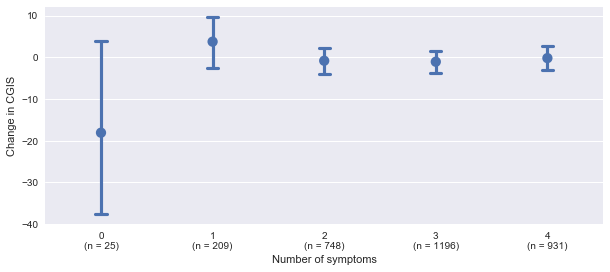

In [35]:
sns.color_palette("Set2")
order = [0, 1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(10, 4))
sns.pointplot(data=df, x="count_symptoms", y="cgis_change", 
              errorbar=('ci', 95), capsize=.1, order=order, join=False
             )

ax.set_xlabel("Number of symptoms")
ax.set_ylabel("Change in CGIS")
ax.set_xticklabels(["0" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 0, :].shape[0]) + ")", 
                    "1" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 1, :].shape[0]) + ")", 
                    "2" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 2, :].shape[0]) + ")", 
                    "3" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 3, :].shape[0]) + ")", 
                    "4" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 4, :].shape[0]) + ")", 
                    "5" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 5, :].shape[0]) + ")"])

In [36]:
kruskal(df.loc[df['count_symptoms'] == 0, :]['cgis_change'], 
        df.loc[df['count_symptoms'] == 1, :]['cgis_change'], 
        df.loc[df['count_symptoms'] == 2, :]['cgis_change'], 
        df.loc[df['count_symptoms'] == 3, :]['cgis_change'], 
        df.loc[df['count_symptoms'] == 4, :]['cgis_change'], 
        df.loc[df['count_symptoms'] == 5, :]['cgis_change'])

KruskalResult(statistic=7.5783304778319405, pvalue=0.18105701427343945)

In [37]:
ols_formula = 'cgis_change ~ C(count_symptoms)'
OLS = ols(formula=ols_formula, data=df)
model = OLS.fit()
model_results = model.summary()
print(model_results)

print(sm.stats.anova_lm(model, typ=2))
tukey_oneway = pairwise_tukeyhsd(endog = df["cgis_change"], groups = df["count_symptoms"])
tukey_oneway.summary()

                            OLS Regression Results                            
Dep. Variable:            cgis_change   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.395
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.223
Time:                        23:39:10   Log-Likelihood:                -17787.
No. Observations:                3400   AIC:                         3.559e+04
Df Residuals:                    3394   BIC:                         3.562e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                -18

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,21.8319,0.2036,-5.5057,49.1695,False
0,2,17.2571,0.4208,-9.0071,43.5213,False
0,3,17.016,0.4302,-9.0887,43.1206,False
0,4,17.8903,0.3738,-8.2903,44.0709,False
0,5,14.5994,0.616,-12.3236,41.5223,False
1,2,-4.5748,0.7635,-14.6819,5.5323,False
1,3,-4.8159,0.6901,-14.5009,4.869,False
1,4,-3.9416,0.8524,-13.8294,5.9462,False
1,5,-7.2325,0.4917,-18.9454,4.4803,False
2,3,-0.2411,0.9,-6.263,5.7807,False


## Number of symptoms vs count of adjunctive medications

[Text(0, 0, '0\n(n = 25)'),
 Text(0, 0, '1\n(n = 209)'),
 Text(0, 0, '2\n(n = 748)'),
 Text(0, 0, '3\n(n = 1196)'),
 Text(0, 0, '4\n(n = 931)'),
 Text(0, 0, '5\n(n = 291)')]

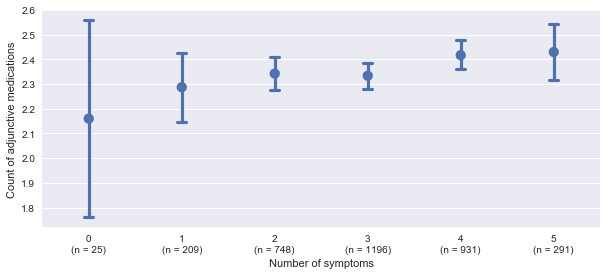

In [38]:
sns.color_palette("Set2")
order = [0, 1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(10, 4))
sns.pointplot(data=df, x="count_symptoms", y="count_meds", 
              errorbar=('ci', 95), capsize=.1, order=order, join=False
             )

ax.set_xlabel("Number of symptoms")
ax.set_ylabel("Count of adjunctive medications")
ax.set_xticklabels(["0" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 0, :].shape[0]) + ")", 
                    "1" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 1, :].shape[0]) + ")", 
                    "2" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 2, :].shape[0]) + ")", 
                    "3" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 3, :].shape[0]) + ")", 
                    "4" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 4, :].shape[0]) + ")", 
                    "5" + "\n" + "(n = " + str(df.loc[df['count_symptoms'] == 5, :].shape[0]) + ")"])

In [39]:
kruskal(df.loc[df['count_symptoms'] == 0, :]['count_meds'], 
        df.loc[df['count_symptoms'] == 1, :]['count_meds'], 
        df.loc[df['count_symptoms'] == 2, :]['count_meds'], 
        df.loc[df['count_symptoms'] == 3, :]['count_meds'], 
        df.loc[df['count_symptoms'] == 4, :]['count_meds'], 
        df.loc[df['count_symptoms'] == 5, :]['count_meds'])

KruskalResult(statistic=7.506674192225559, pvalue=0.18560154125832395)

In [40]:
ols_formula = 'count_meds ~ C(count_symptoms)'
OLS = ols(formula=ols_formula, data=df)
model = OLS.fit()
model_results = model.summary()
print(model_results)

print(sm.stats.anova_lm(model, typ=2))
tukey_oneway = pairwise_tukeyhsd(endog = df["count_meds"], groups = df["count_symptoms"])
tukey_oneway.summary()

                            OLS Regression Results                            
Dep. Variable:             count_meds   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.637
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.147
Time:                        23:39:10   Log-Likelihood:                -4688.1
No. Observations:                3400   AIC:                             9388.
Df Residuals:                    3394   BIC:                             9425.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.1271,0.9,-0.4531,0.7073,False
0,2,0.1822,0.9,-0.3752,0.7397,False
0,3,0.1736,0.9,-0.3804,0.7276,False
0,4,0.2568,0.748,-0.2989,0.8124,False
0,5,0.2696,0.7321,-0.3018,0.841,False
1,2,0.0552,0.9,-0.1593,0.2697,False
1,3,0.0465,0.9,-0.159,0.2521,False
1,4,0.1297,0.4909,-0.0802,0.3395,False
1,5,0.1425,0.5652,-0.1061,0.3911,False
2,3,-0.0086,0.9,-0.1364,0.1192,False


## Count of adjunctive medications vs change in cgis

[Text(0, 0, '0\n(n = 79)'),
 Text(0, 0, '1\n(n = 540)'),
 Text(0, 0, '2\n(n = 1254)'),
 Text(0, 0, '3\n(n = 1124)'),
 Text(0, 0, '4\n(n = 403)')]

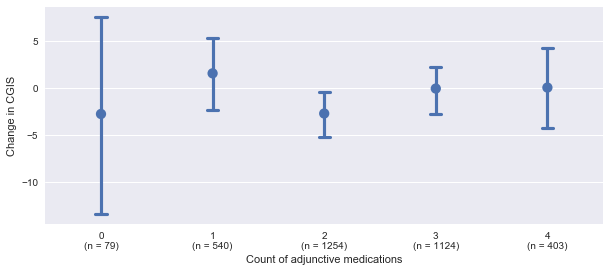

In [41]:
sns.color_palette("Set2")
order = [0, 1, 2, 3, 4]

fig, ax = plt.subplots(figsize=(10, 4))
sns.pointplot(data=df, x="count_meds", y="cgis_change", 
              errorbar=('ci', 95), capsize=.1, order=order, join=False
             )

ax.set_xlabel("Count of adjunctive medications")
ax.set_ylabel("Change in CGIS")
ax.set_xticklabels(["0" + "\n" + "(n = " + str(df.loc[df['count_meds'] == 0, :].shape[0]) + ")", 
                    "1" + "\n" + "(n = " + str(df.loc[df['count_meds'] == 1, :].shape[0]) + ")", 
                    "2" + "\n" + "(n = " + str(df.loc[df['count_meds'] == 2, :].shape[0]) + ")", 
                    "3" + "\n" + "(n = " + str(df.loc[df['count_meds'] == 3, :].shape[0]) + ")", 
                    "4" + "\n" + "(n = " + str(df.loc[df['count_meds'] == 4, :].shape[0]) + ")"])

In [42]:
kruskal(df.loc[df['count_meds'] == 0, :]['cgis_change'], 
        df.loc[df['count_meds'] == 1, :]['cgis_change'], 
        df.loc[df['count_meds'] == 2, :]['cgis_change'], 
        df.loc[df['count_meds'] == 3, :]['cgis_change'], 
        df.loc[df['count_meds'] == 4, :]['cgis_change'])

KruskalResult(statistic=5.561121426507073, pvalue=0.23440887068330493)

In [43]:
ols_formula = 'cgis_change ~ C(count_meds)'
OLS = ols(formula=ols_formula, data=df)
model = OLS.fit()
model_results = model.summary()
print(model_results)

print(sm.stats.anova_lm(model, typ=2))
tukey_oneway = pairwise_tukeyhsd(endog = df["cgis_change"], groups = df["count_meds"])
tukey_oneway.summary()

                            OLS Regression Results                            
Dep. Variable:            cgis_change   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.072
Date:                Wed, 12 Jun 2024   Prob (F-statistic):              0.369
Time:                        23:39:11   Log-Likelihood:                -17788.
No. Observations:                3400   AIC:                         3.559e+04
Df Residuals:                    3395   BIC:                         3.562e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -2.7272      5

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,4.3244,0.9,-10.5738,19.2226,False
0,2,0.0512,0.9,-14.2955,14.3979,False
0,3,2.7046,0.9,-11.6912,17.1004,False
0,4,2.8106,0.9,-12.4074,18.0286,False
1,2,-4.2732,0.3557,-10.6392,2.0928,False
1,3,-1.6197,0.9,-8.0956,4.8561,False
1,4,-1.5138,0.9,-9.6553,6.6277,False
2,3,2.6535,0.5964,-2.4266,7.7336,False
2,4,2.7594,0.8018,-4.3226,9.8415,False
3,4,0.1059,0.9,-7.075,7.2869,False
